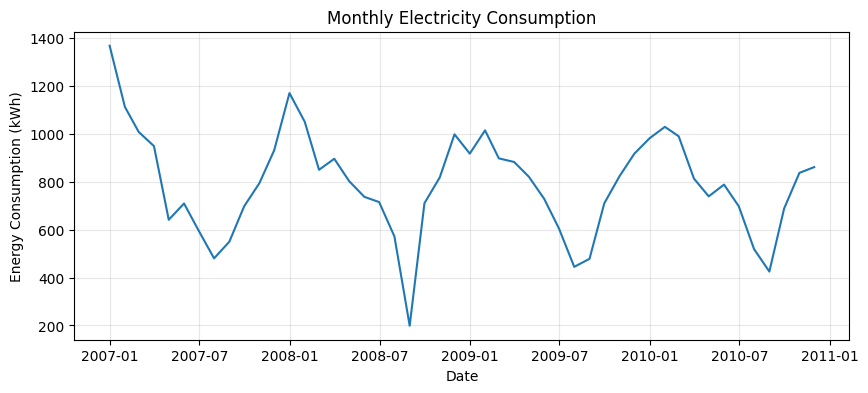

ADF Statistic: -4.897270331927381
p-value: 3.5303542477698e-05
                                     SARIMAX Results                                      
Dep. Variable:                Global_active_power   No. Observations:                   36
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -52.470
Date:                            Sat, 07 Feb 2026   AIC                            114.939
Time:                                    10:19:32   BIC                            115.925
Sample:                                12-31-2006   HQIC                           112.811
                                     - 11-30-2009                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7153      0.777     -0.920      0.

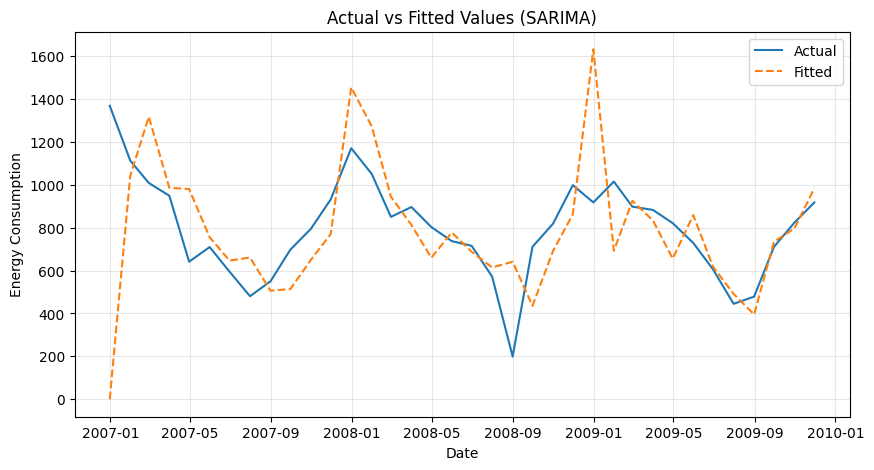

MAE: 142.71404935555566
RMSE: 165.63355852173845


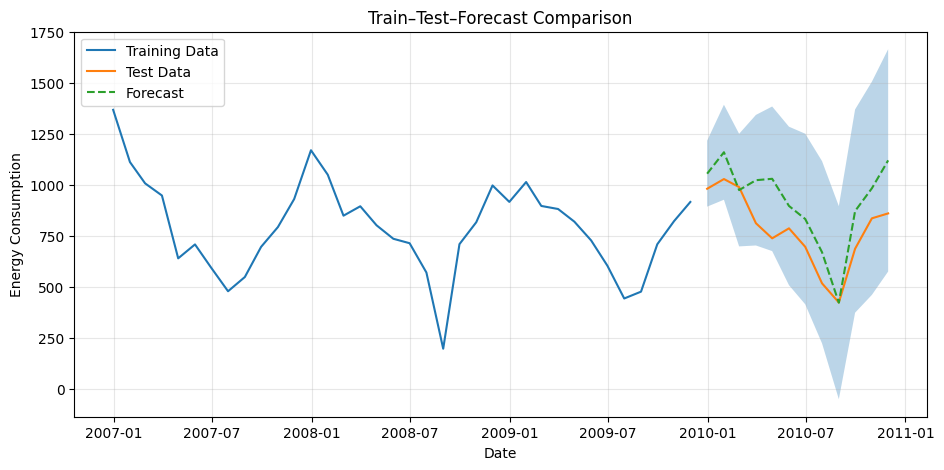

<Figure size 1000x500 with 0 Axes>

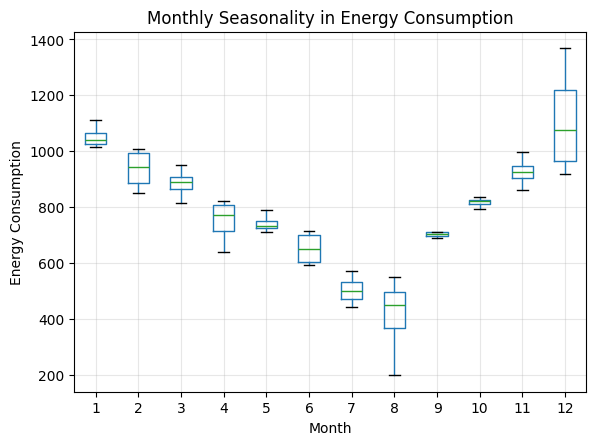

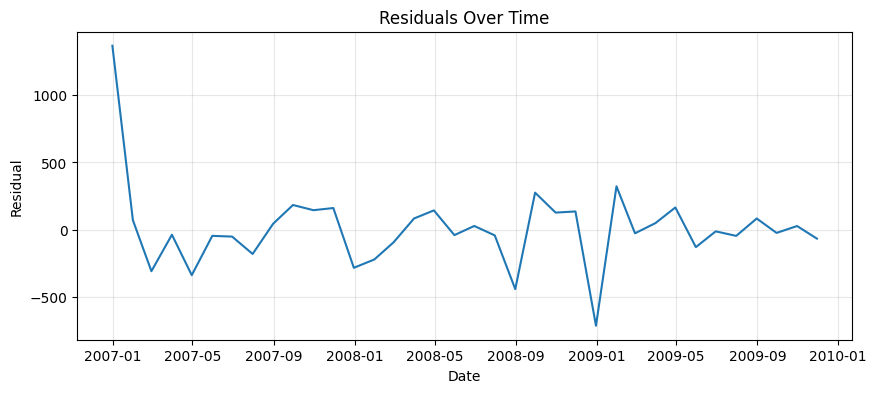

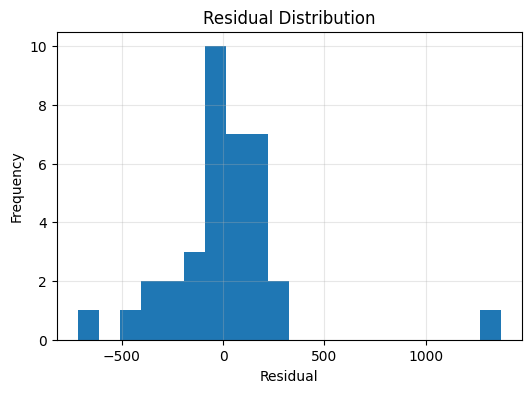

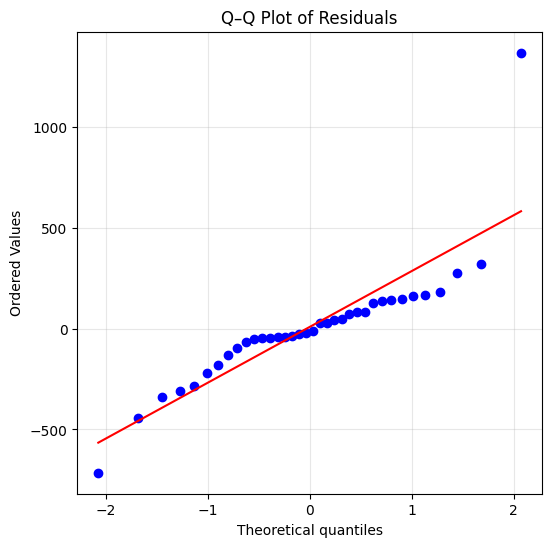

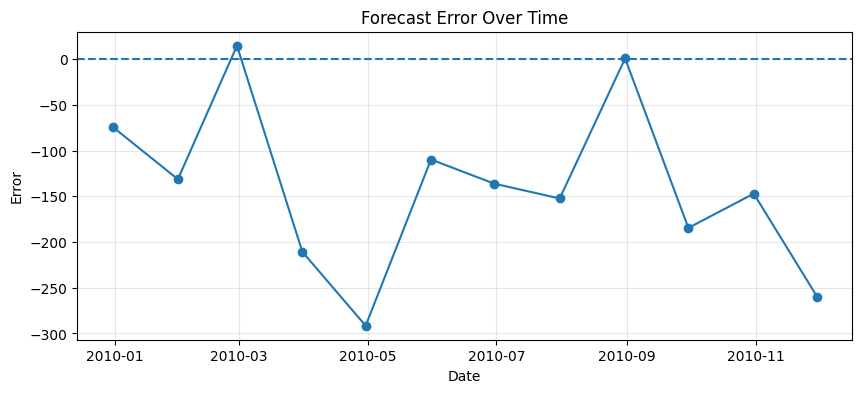

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("dataset.txt", sep=";", na_values="?")

df["Datetime"] = pd.to_datetime(
    df["Date"] + " " + df["Time"],
    format="%d/%m/%Y %H:%M:%S"
)

df.set_index("Datetime", inplace=True)
df.drop(["Date", "Time"], axis=1, inplace=True)

df["Global_active_power"] = pd.to_numeric(
    df["Global_active_power"],
    errors="coerce"
)

df = df.dropna()

monthly_df = df["Global_active_power"].resample("M").mean()
monthly_df = monthly_df * 30 * 24

plt.figure(figsize=(10,4))
plt.plot(monthly_df)
plt.title("Monthly Electricity Consumption")
plt.xlabel("Date")
plt.ylabel("Energy Consumption (kWh)")
plt.grid(alpha=0.3)
plt.show()

adf_stat, p_value, *_ = adfuller(monthly_df)
print("ADF Statistic:", adf_stat)
print("p-value:", p_value)

train = monthly_df.iloc[:-12]
test = monthly_df.iloc[-12:]

model = SARIMAX(
    train,
    order=(1,1,1),
    seasonal_order=(1,1,1,12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit()
print(results.summary())

fitted = results.fittedvalues

plt.figure(figsize=(10,5))
plt.plot(train, label="Actual")
plt.plot(fitted, linestyle="--", label="Fitted")
plt.title("Actual vs Fitted Values (SARIMA)")
plt.xlabel("Date")
plt.ylabel("Energy Consumption")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

forecast = results.get_forecast(steps=12)
pred = forecast.predicted_mean
conf_int = forecast.conf_int()

mae = mean_absolute_error(test, pred)
rmse = np.sqrt(mean_squared_error(test, pred))

print("MAE:", mae)
print("RMSE:", rmse)

plt.figure(figsize=(11,5))
plt.plot(train, label="Training Data")
plt.plot(test, label="Test Data")
plt.plot(pred, linestyle="--", label="Forecast")
plt.fill_between(
    conf_int.index,
    conf_int.iloc[:,0],
    conf_int.iloc[:,1],
    alpha=0.3
)
plt.title("Train–Test–Forecast Comparison")
plt.xlabel("Date")
plt.ylabel("Energy Consumption")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

monthly_df_df = monthly_df.to_frame(name="Consumption")
monthly_df_df["Month"] = monthly_df_df.index.month

plt.figure(figsize=(10,5))
monthly_df_df.boxplot(column="Consumption", by="Month")
plt.title("Monthly Seasonality in Energy Consumption")
plt.suptitle("")
plt.xlabel("Month")
plt.ylabel("Energy Consumption")
plt.grid(alpha=0.3)
plt.show()

residuals = results.resid

plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title("Residuals Over Time")
plt.xlabel("Date")
plt.ylabel("Residual")
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(6,4))
plt.hist(residuals, bins=20)
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(6,6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q–Q Plot of Residuals")
plt.grid(alpha=0.3)
plt.show()

forecast_error = test - pred

plt.figure(figsize=(10,4))
plt.plot(forecast_error, marker="o")
plt.axhline(0, linestyle="--")
plt.title("Forecast Error Over Time")
plt.xlabel("Date")
plt.ylabel("Error")
plt.grid(alpha=0.3)
plt.show()
